In [1]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from gensim.models import word2vec

def clean_article(article, remove_stopwords = True):
    article_text = BeautifulSoup(article).get_text()     
    letters_only = re.sub("[^a-zA-Z]", " ", article_text) 
    words = letters_only.lower().split()    
    if remove_stopwords:                         
      stops = set(stopwords.words("english"))                  
      words = [w for w in words if not w in stops]   
    cleaned_article = words   
    return cleaned_article

def article_to_sentences( article: str, tokenizer: nltk.tokenize.punkt.PunktSentenceTokenizer ):
    sentences = tokenizer.tokenize(article)
    cleaned_sentences = []
    for sentence in sentences:
      cleaned_sentence = clean_article(sentence)
      cleaned_sentences.append(cleaned_sentence)
    article_sentences = cleaned_sentences
    
    return article_sentences

nltk.download('punkt')
nltk.download('stopwords')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train['text'].dropna(inplace=True)
test['text'].dropna(inplace=True)

sentences = []
num_sentences_per_article = []
num_tokens_per_sentence = []
for article in train['text']:
    cleaned_article_sentences = article_to_sentences(article, tokenizer)
    num_sentences_per_article.append(len(cleaned_article_sentences))
    for sentence in cleaned_article_sentences:
        num_tokens_per_sentence.append(len(sentence))
        sentences.append(sentence)


trained_word2vec_model = word2vec.Word2Vec(sentences, workers=4, \
            size=100, min_count = 40, \
            window = 5, sample = 1e-3)

[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.dailytelegraph.com.au/rendezview/miranda-devine-foreignfunded-green-groups-could-take-whole-swathes-of-australia-out-of-the-productive-economy/news-story/016e5d9ff252f2444790d05269f4ed90" l

/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://petras.lahaine.org" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://t.co/n9kIJKSUEW" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [2]:
num_articles_train = len(train['text'])
num_reliable_train = len(train[(train['label']==0)])
num_fake_train = len(train[(train['label']==1)])
num_articles_test = len(test['text'])
num_words_vocab = len(trained_word2vec_model.wv.vocab)
average_sentences_per_article = sum(num_sentences_per_article)/len(num_sentences_per_article)
average_tokens_per_sentence = sum(num_tokens_per_sentence)/len(num_tokens_per_sentence)
top_10_words = trained_word2vec_model.wv.index2entity[:10]
top_10_word_frequencies = [trained_word2vec_model.wv.vocab[word].count for word in top_10_words]

In [3]:
for i in range(10):
    print(top_10_word_frequencies[i],top_10_words[i])

80054 said
66294 mr
56289 trump
38670 one
37358 would
36542 people
30062 new
27442 clinton
26346 like
25448 also


In [4]:
def calculate_sparsity(train, w2v_model):
    vocab = w2v_model.wv.vocab
    distinct_word_count = 0
    for cleaned_article_sentences in sentences:
        words = set([item for sublist in cleaned_article_sentences for item in sublist])
        distinct_word_count += len(words)
    sparsity = 1 - (distinct_word_count/(len(train)*len(vocab)))
    return sparsity

sparsity = calculate_sparsity(train,trained_word2vec_model)


        

/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  app.launch_new_instance()
/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in

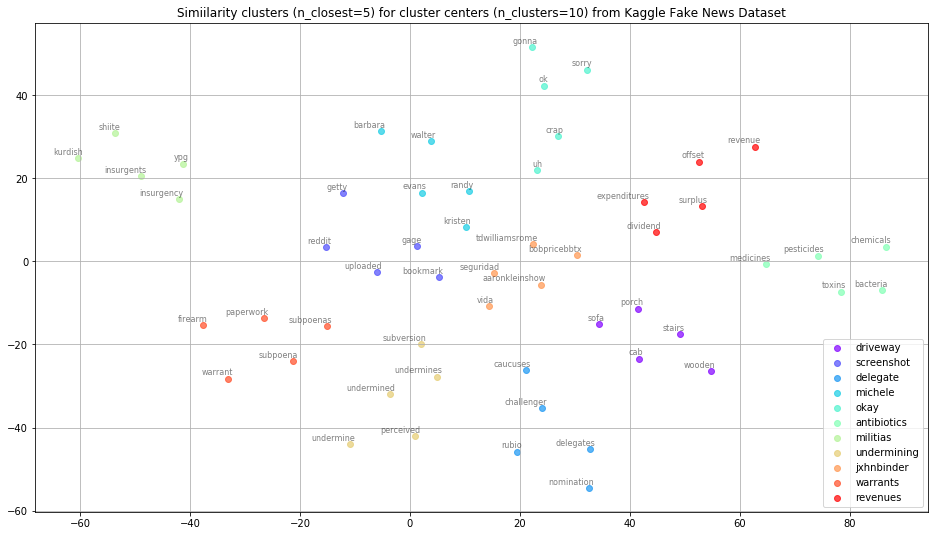

In [5]:
#Generate cluster visualization plot

from sklearn.cluster import KMeans
def clustering_on_wordvecs(word_vectors, num_clusters=10):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

Z = trained_word2vec_model.wv.syn0;
centers, clusters = clustering_on_wordvecs(Z, 11);
centroid_map = dict(zip(trained_word2vec_model.wv.index2word, clusters));
center_words = []
for vec in centers:
    center_words.append(trained_word2vec_model.most_similar(positive=[vec], topn=1))

keys = [word[0][0] for word in center_words]
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in trained_word2vec_model.most_similar(word, topn=5):
        words.append(similar_word)
        embeddings.append(trained_word2vec_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Simiilarity clusters (n_closest=5) for cluster centers (n_clusters=10) from Kaggle Fake News Dataset', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')



In [6]:
fake_train = train[(train['label']==1)]
real_train = train[(train['label']==0)]
fake_train['text'].dropna(inplace=True)
real_train['text'].dropna(inplace=True)

fake_sentences = []
real_sentences = []

for article in fake_train['text']:
    cleaned_article_sentences = article_to_sentences(article, tokenizer)
    for sentence in cleaned_article_sentences:
        fake_sentences.append(sentence)
        
for article in real_train['text']:
    cleaned_article_sentences = article_to_sentences(article, tokenizer)
    for sentence in cleaned_article_sentences:
        real_sentences.append(sentence)
        
fake_trained_word2vec_model = word2vec.Word2Vec(fake_sentences, workers=4, \
            size=100, min_count = 40, \
            window = 5, sample = 1e-3)
real_trained_word2vec_model = word2vec.Word2Vec(real_sentences, workers=4, \
            size=100, min_count = 40, \
            window = 5, sample = 1e-3)

top_10_fake_words = fake_trained_word2vec_model.wv.index2entity[:10]
top_10_real_words = real_trained_word2vec_model.wv.index2entity[:10]
top_10_fake_word_frequencies = [fake_trained_word2vec_model.wv.vocab[word].count for word in top_10_fake_words]
top_10_real_word_frequencies = [real_trained_word2vec_model.wv.vocab[word].count for word in top_10_real_words]


/Users/kai/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:4787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.dailytelegraph.com.au/rendezview/miranda-devine-foreignfunded-green-groups-could-take-whol

/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://petras.lahaine.org" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/kai/miniconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://t.co/n9kIJKSUEW" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [7]:
for i in range(10):
    print(top_10_fake_word_frequencies[i],top_10_fake_words[i])
for i in range(10):
    print(top_10_real_word_frequencies[i],top_10_real_words[i])

20170 trump
19296 clinton
16600 people
16128 one
14942 us
14555 would
12770 hillary
11875 said
10401 new
10324 like
68179 said
64571 mr
36119 trump
22803 would
22542 one
19942 people
19661 new
16829 president
16022 like
15527 also


In [8]:
fake_train['title'].dropna(inplace=True)
real_train['title'].dropna(inplace=True)

percent_words_capital_fake = []
percent_words_capital_real = []
for title in fake_train['title']:
    num_capital_words = 0
    num_words = 0
    words = title.split()
    for word in words:
        if word.isupper():
            num_capital_words += 1
        num_words += 1
    percent_words_capital_fake.append(num_capital_words/num_words)
for title in real_train['title']:
    num_capital_words = 0
    num_words = 0
    words = title.split()
    for word in words:
        if word.isupper():
            num_capital_words += 1
        num_words += 1
    percent_words_capital_real.append(num_capital_words/num_words)
        

/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


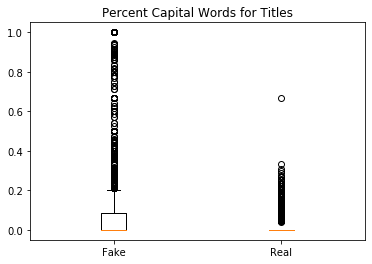

In [9]:
average_percent_capital_fake = sum(percent_words_capital_fake)/len(percent_words_capital_fake)
average_percent_capital_real = sum(percent_words_capital_real)/len(percent_words_capital_real)
min_percent_capital_fake = min(percent_words_capital_fake)
min_percent_capital_real = min(percent_words_capital_real)
max_percent_capital_fake = max(percent_words_capital_fake)
max_percent_capital_real = max(percent_words_capital_real)

def get_percent_capital_boxplots():
    # Create a figure instance
    plt.title("Percent Capital Words for Titles")
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    ax.set_xticklabels(['Fake', 'Real'])

    # Create the boxplot
    bp = ax.boxplot([percent_words_capital_fake,percent_words_capital_real])

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')
    plt.savefig("percent_capital.png", format='png', dpi=150, bbox_inches='tight')

get_percent_capital_boxplots()

/Users/kai/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:4787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)
/Users/kai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


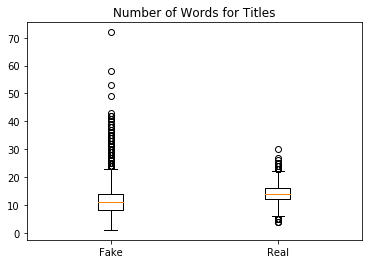

In [10]:
fake_train['title'].dropna(inplace=True)
real_train['title'].dropna(inplace=True)

title_length_fake = []
title_length_real = []
for title in fake_train['title']:
    words = title.split()
    title_length_fake.append(len(words))
for title in real_train['title']:
    words = title.split()
    title_length_real.append(len(words))

def get_title_length_boxplots():
    # Create a figure instance
    plt.title("Number of Words for Titles")
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    ax.set_xticklabels(['Fake', 'Real'])

    # Create the boxplot
    bp = ax.boxplot([title_length_fake,title_length_real])

    # Save the figure
    plt.savefig("title_length.png", format='png', dpi=150, bbox_inches='tight')

get_title_length_boxplots()